In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="3"
sys.path.insert(1,'/home/jgozlan/GIT/scripts/')
sys.path.insert(1, '/home/jgozlan/GIT/models_analysis/')
#from tensorflow import keras
import keras
from keras import losses
from keras.callbacks import EarlyStopping
from keras.optimizers import adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.metrics import MeanAbsolutePercentageError

import matplotlib.pyplot as plt
import numpy as np
import samplerate
from numpy import array, hstack, unique, where
import statsmodels.api as sm 

import tensorflow as tf
tf.test.is_gpu_available()

from imu_extractor import get_all_dataframes_for_forecasting, get_freq_magn, transform_dataset_into_freq_magn
from train_test_split_multi import get_train_test_split
from baseline import find_frequency, get_forecast_baseline_dict, get_mean_acf_peak_value_for_signals,  plot_forecasts_multi
from models import create_lstm_encoder_decoder, create_dropout_predict_function
from evaluation2 import plot_forecasts, plot_metrics, plot_metrics_multi


Using TensorFlow backend.


In [2]:

path_cluster0 = ['Run_Features','Walk_Features']

path_cluster1 = ['CarDriving_Features']

path_cluster2 = ['Karting_Features',
                 'MotorcycleHelmet_Features',
                 'Scooter_Features','SkateboardChesty_Features',
                 'SnowboardSeeker_Features','Hiking_Features']

path_all_classes = path_cluster0 + path_cluster1 + path_cluster2

recording_freq = 6400.0
downsampling_freq = 200.0

all_dfs_classes = []

# load all recordings from all clusters
for i,c in enumerate(path_all_classes):
    dfs = get_all_dataframes_for_forecasting("Database/" + c, recording_freq, downsampling_freq)
    all_dfs_classes.append(dfs)
    
all_df = [item for sublist in all_dfs_classes for item in sublist]

GH010029.MP4.eis_dump.bin_features.json
GH010011.MP4.eis_dump.bin_features.json
GH019983.MP4.eis_dump.bin_features.json
GH010019.MP4.eis_dump.bin_features.json
GH010030.MP4.eis_dump.bin_features.json
GH010028.MP4.eis_dump.bin_features.json
GH019982.MP4.eis_dump.bin_features.json
GH010012.MP4.eis_dump.bin_features.json
GH019973.MP4.eis_dump.bin_features.json
GH010018.MP4.eis_dump.bin_features.json
GH019969.MP4.eis_dump.bin_features.json
GH010034.MP4.eis_dump.bin_features.json
GH010014.MP4.eis_dump.bin_features.json
GH019975.MP4.eis_dump.bin_features.json
GH010004.MP4.eis_dump.bin_features.json
GH010005.MP4.eis_dump.bin_features.json
GH010019.MP4.eis_dump.bin_features.json
GH019968.MP4.eis_dump.bin_features.json
GH010035.MP4.eis_dump.bin_features.json
GH019976.MP4.eis_dump.bin_features.json
GH010013.MP4.eis_dump.bin_features.json
GH019980.MP4.eis_dump.bin_features.json
GH010012.MP4.eis_dump.bin_features.json
GX010006.MP4.eis_dump.bin_features.json
filtering median....
GX010002.MP4.eis_du

In [3]:
# sequence parameter 
lag = 500
ahead = 100
delay = 5
test_size = 0.2
dim = 12
target_index = [0,1,2] # gyro axes indexes
classification = False

X_train, y_train, X_test, y_test = get_train_test_split(all_df, test_size, lag, ahead, delay, target_index, classification = False)

In [4]:
# number of harmonics
num_freq = 12

# transform the dasasets into their corresponding frequency version
transformed_X_train = transform_dataset_into_freq_magn(X_train[:,:,:6], downsampling_freq, num_freq)
transformed_X_test = transform_dataset_into_freq_magn(X_test[:,:,:6], downsampling_freq, num_freq)

freq_dim_in = transformed_X_train.shape[1]

In [5]:
# load all models
# the cluster classification model for 4 clusters, 6 harmonics and 5 step delay (neural net)
cluster_classification_model = keras.models.load_model('models_analysis/cluster_classification_model_4c_6f_5step')

# global forecasting model ( trained on all activities)
global_forecasting_model = keras.models.load_model('models_analysis/global_forecasting_multi_5step',custom_objects={"MeanAbsolutePercentageError":MeanAbsolutePercentageError()}, compile= False)

# load forecasting models for each cluster
cluster0_model = keras.models.load_model('models_analysis/cluster0_forecasting_multi_5step', custom_objects={"MeanAbsolutePercentageError":MeanAbsolutePercentageError()}, compile= False)
cluster1_model = keras.models.load_model('models_analysis/cluster1_forecasting_multi_5step', custom_objects={"MeanAbsolutePercentageError":MeanAbsolutePercentageError()}, compile= False)
cluster2_model = keras.models.load_model('models_analysis/cluster2_forecasting_multi_5step', custom_objects={"MeanAbsolutePercentageError":MeanAbsolutePercentageError()}, compile= False)
cluster3_model = keras.models.load_model('models_analysis/cluster3_forecasting_multi_5step', custom_objects={"MeanAbsolutePercentageError":MeanAbsolutePercentageError()}, compile= False)

# dropout version
dropout = 0.05
cluster0_predict_with_dropout = create_dropout_predict_function(cluster0_model, dropout)
cluster1_predict_with_dropout = create_dropout_predict_function(cluster1_model, dropout)
cluster2_predict_with_dropout = create_dropout_predict_function(cluster2_model, dropout)
cluster3_predict_with_dropout = create_dropout_predict_function(cluster3_model, dropout)


cluster_models = [cluster0_model, cluster1_model, cluster2_model, cluster3_model]
cluster_dropout_models = [cluster0_predict_with_dropout, cluster1_predict_with_dropout, cluster2_predict_with_dropout, cluster3_predict_with_dropout]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
# forecast
global_forecast = global_forecasting_model.predict(X_test)

predictions_cluster0 = cluster0_model.predict(X_test)
predictions_cluster1 = cluster1_model.predict(X_test)
predictions_cluster2 = cluster2_model.predict(X_test)
predictions_cluster3 = cluster3_model.predict(X_test)

In [7]:
predictions_clusters = [predictions_cluster0, predictions_cluster1, predictions_cluster2, predictions_cluster3]

In [8]:
# pipeline parameters 
batch_pipeline_size = 100 
threshold_softmax  = 0.75 # threshold for softmax values ( if lower, discard it)
threshold_acf = 0.6 # minimum three axis mean acf periodicity metric, if lower discard sample.

predictions_cluster_class_acf = np.zeros((X_test.shape[0], ahead, 3))

predictions_cluster_class_acf_index = np.ones((X_test.shape[0])) * -1

predictions_cluster_class = np.zeros((X_test.shape[0], ahead, 3))


for i in range(0, len(X_test), batch_pipeline_size):
    
    if (i % 10000) == 0:
        print(i)

    batch_time = X_test[i: (i+ batch_pipeline_size)]
    batch_freq = transformed_X_test[i: (i+ batch_pipeline_size)]

    # predict cluster class
    cluster_probs = cluster_classification_model.predict(batch_freq)
    # filter the one above the sotmax threshold
    cluster_probs_filtered = cluster_probs > threshold_softmax
    idx0 = np.where(cluster_probs_filtered, cluster_probs ,np.nanmin(cluster_probs)-threshold_softmax).argmax(1)
    idx = np.where(cluster_probs_filtered.any(1), idx0, -1)

    # first check => if all samples in batch has higher than treshold softmax values + are all the same
    if all(x == idx[0] for x in idx) and idx[0] != -1:
      
        acf_value = get_mean_acf_peak_value_for_signals(batch_time[:,:,:3], lag, delay)
        predictions_cluster_class[i:i+batch_pipeline_size] = predictions_clusters[idx[0]][i: i + batch_pipeline_size]
        # check if acf value for the reconstitued sample is higher than the threshold
        if acf_value > threshold_acf:

            predictions_cluster_class_acf[i: i + batch_pipeline_size] = predictions_clusters[idx[0]][i: i + batch_pipeline_size]
            predictions_cluster_class_acf_index[i: i + batch_pipeline_size] = idx[0]

0
10000
20000
30000
40000


In [9]:
# plot metrics + examples
import numpy as np

forecast = predictions_cluster_class
forecast_x = forecast[:,:,0].reshape((forecast.shape[0], forecast.shape[1]))
forecast_y = forecast[:,:,1].reshape((forecast.shape[0], forecast.shape[1]))
forecast_z = forecast[:,:,2].reshape((forecast.shape[0], forecast.shape[1]))

true_x = y_test[:,:,0].reshape((y_test.shape[0], y_test.shape[1]))
true_y = y_test[:,:,1].reshape((y_test.shape[0], y_test.shape[1]))
true_z = y_test[:,:,2].reshape((y_test.shape[0], y_test.shape[1]))

comparison_methods = ["global model", "period acf", "mean","period fourier"]
baseline_dict = get_forecast_baseline_dict(X_test, y_test, global_forecasting_model , 3, lag, ahead, downsampling_freq, comparison_methods)

dict_forecasts_x = {"cluster model": forecast_x}
dict_forecasts_y = {"cluster model": forecast_y}
dict_forecasts_z = {"cluster model": forecast_z}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

dict_forecasts_color = {"cluster model": "blue", "global model": "black", "period acf": "brown","mean":"orange", "period fourier": "yellow","true": "green"}

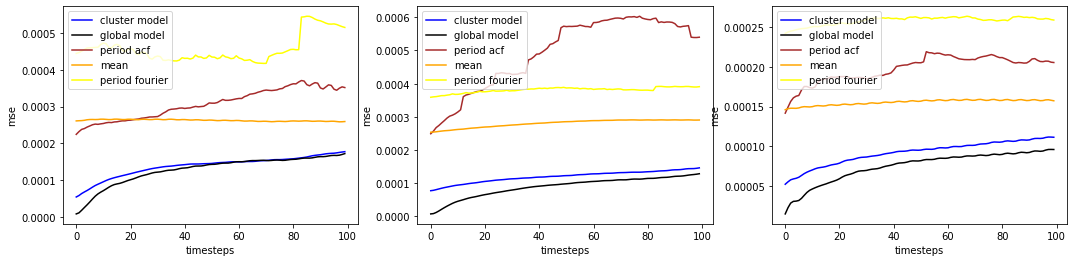

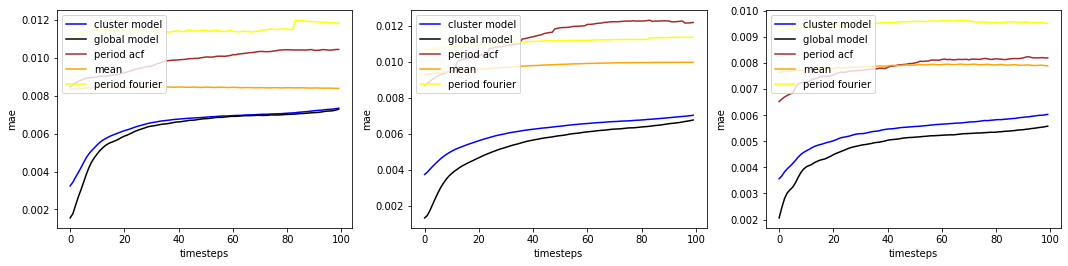

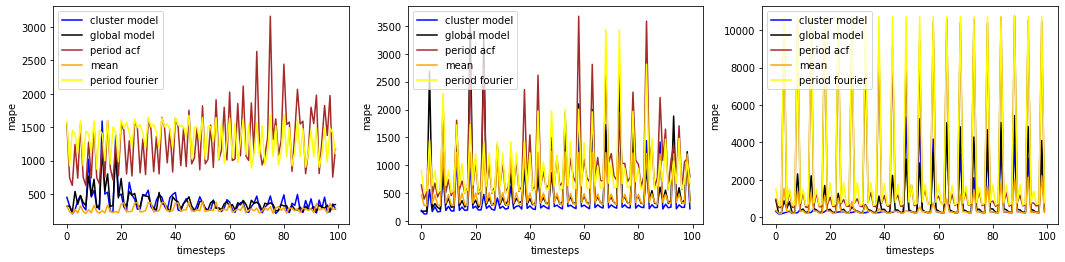

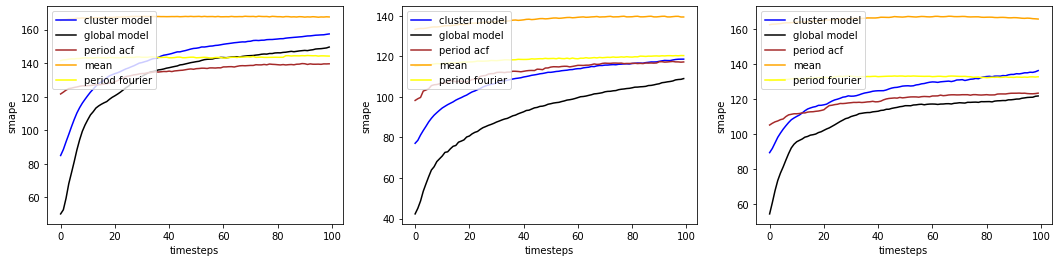

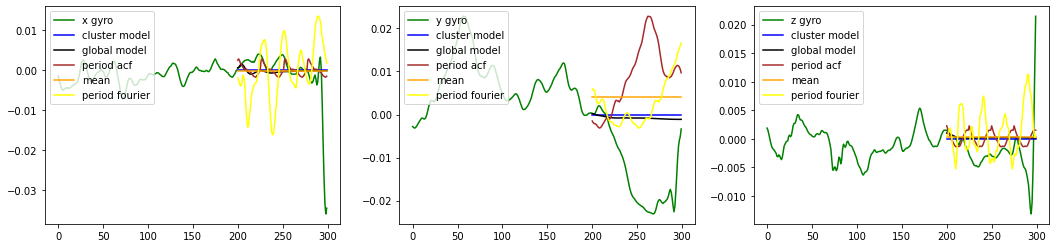

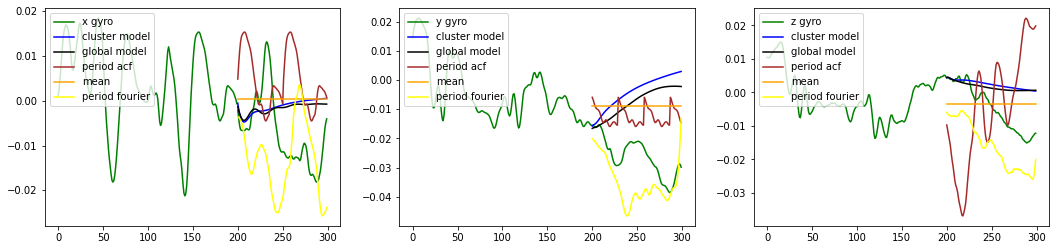

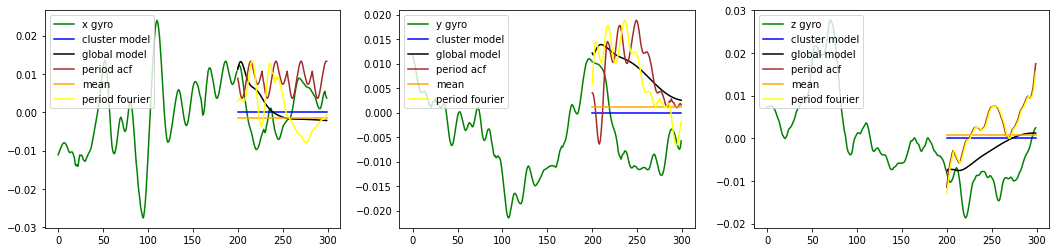

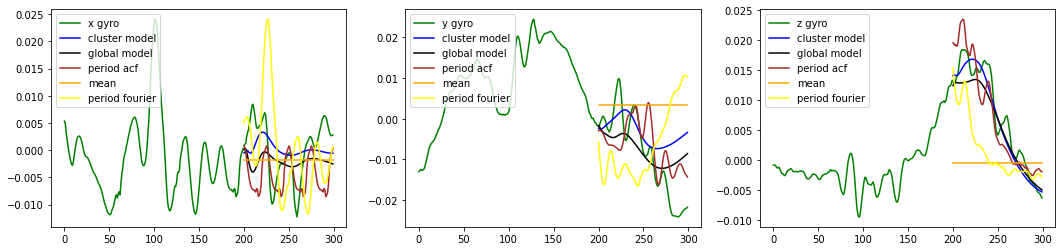

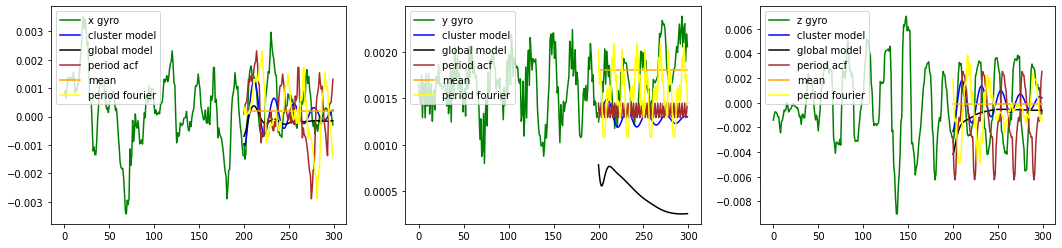

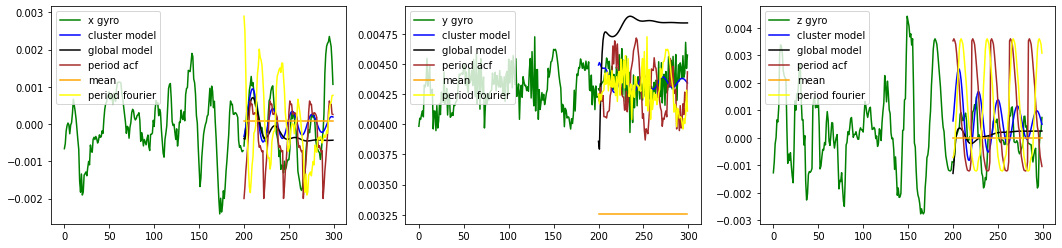

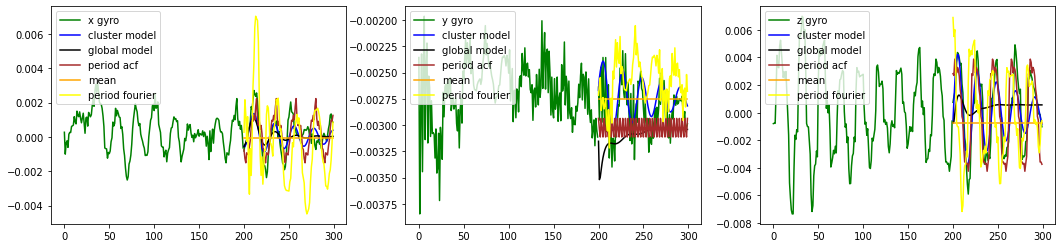

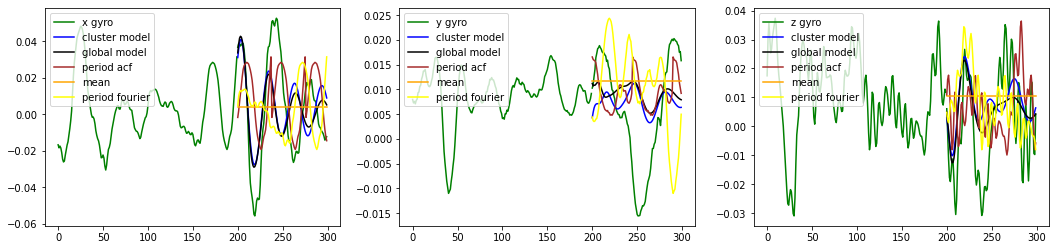

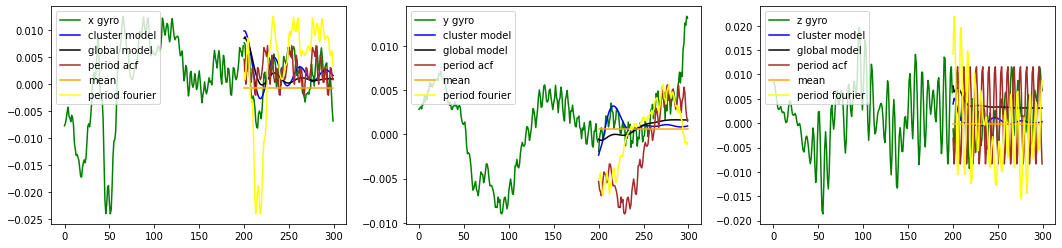

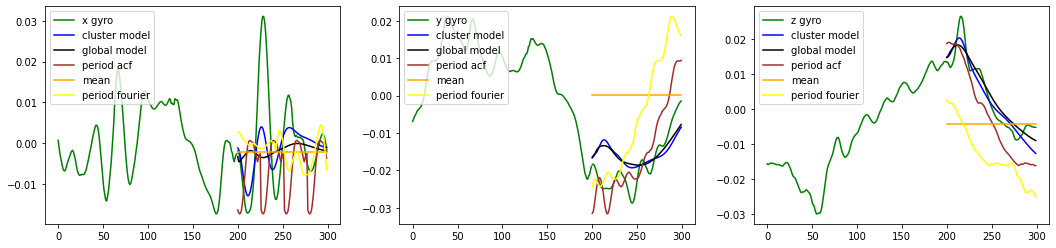

In [11]:
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)
plot_forecasts_multi(X_test, [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)

In [12]:
idx_threshold = np.where(predictions_cluster_class_acf_index != -1)[0]

ratio = len(idx_threshold)/X_test.shape[0]
print(ratio)

forecast_for_threshold_acf = predictions_cluster_class_acf[idx_threshold]
forecast_x_acf = forecast_for_threshold_acf[:,:,0].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_y_acf = forecast_for_threshold_acf[:,:,1].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_z_acf = forecast_for_threshold_acf[:,:,2].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))

true_x = y_test[idx_threshold,:,0].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_y = y_test[idx_threshold,:,1].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_z = y_test[idx_threshold,:,2].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))

baseline_dict = get_forecast_baseline_dict(X_test[idx_threshold], y_test[idx_threshold], global_forecasting_model , 3, lag, ahead, downsampling_freq, comparison_methods)

dict_forecasts_x = {"cluster model": forecast_x_acf}
dict_forecasts_y = {"cluster model": forecast_y_acf}
dict_forecasts_z = {"cluster model": forecast_z_acf}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

0.16189962223421478


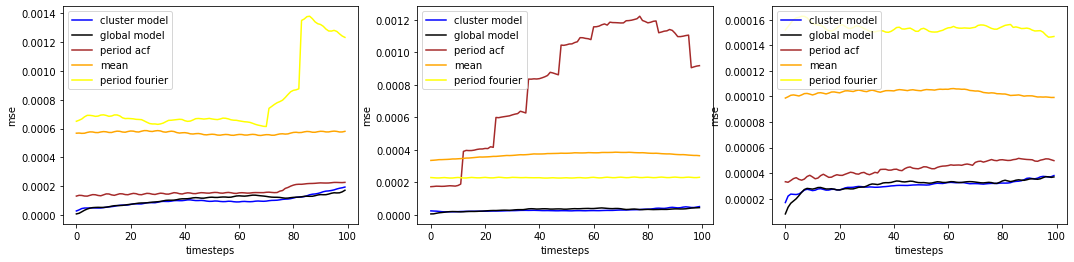

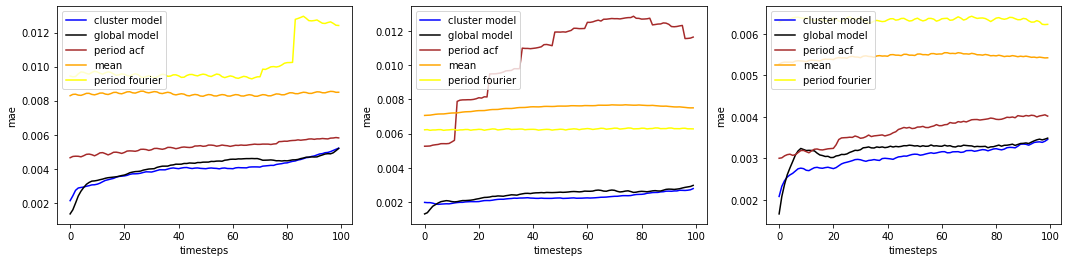

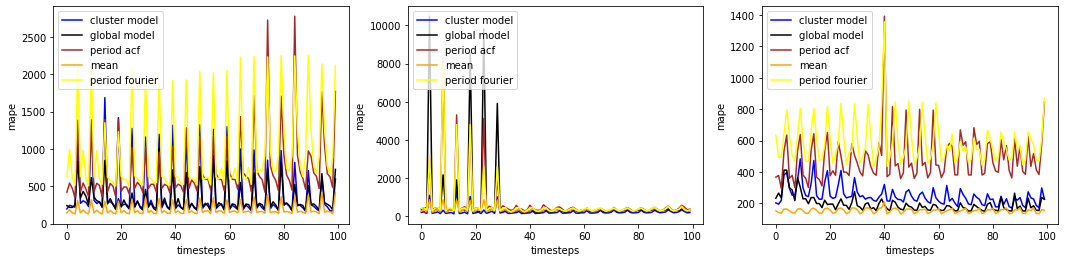

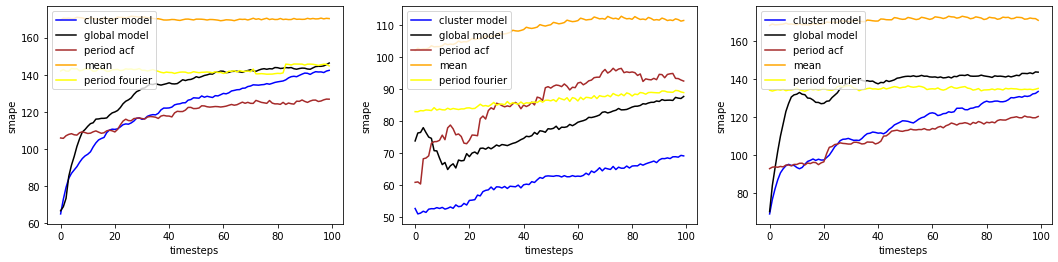

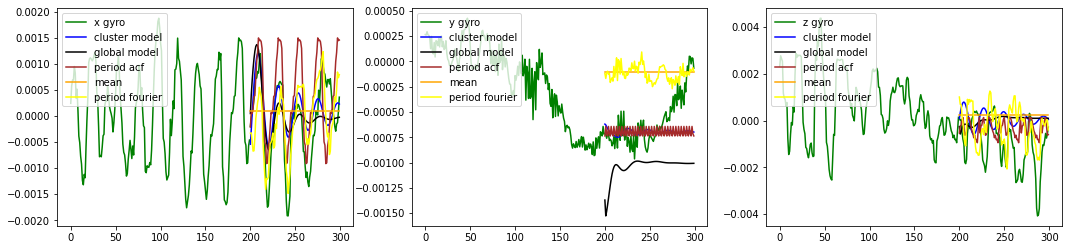

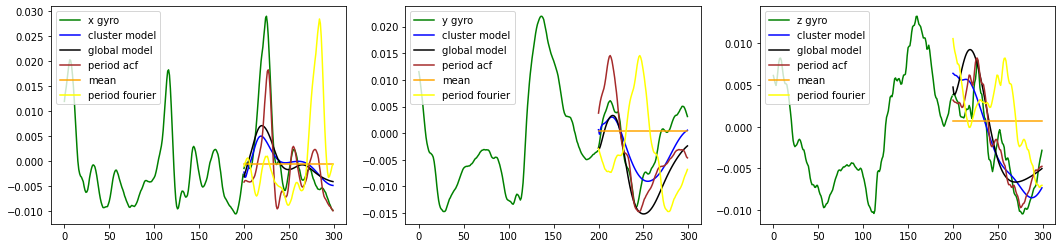

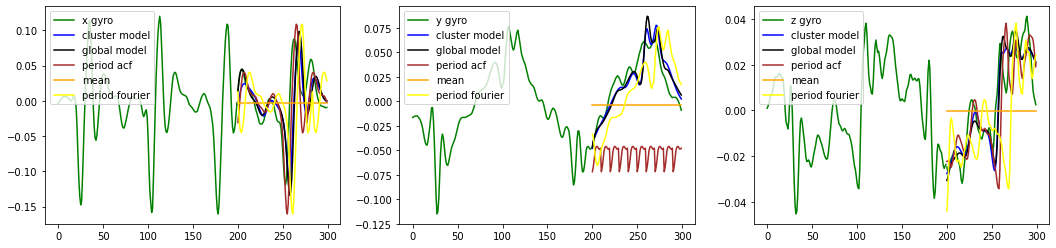

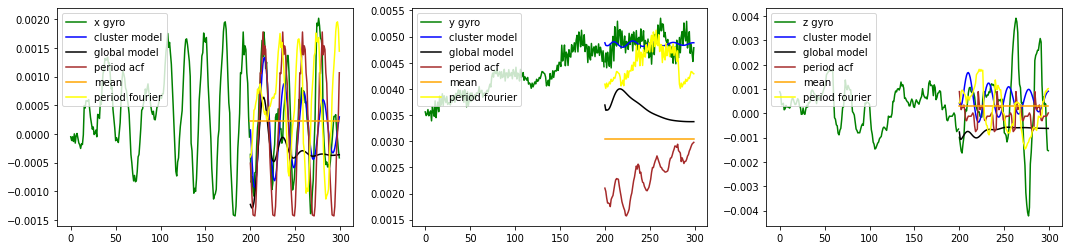

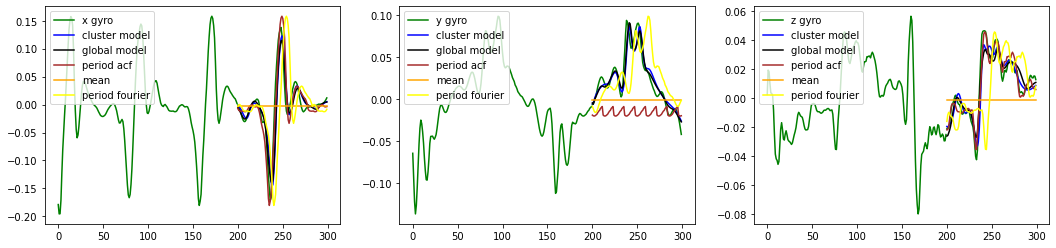

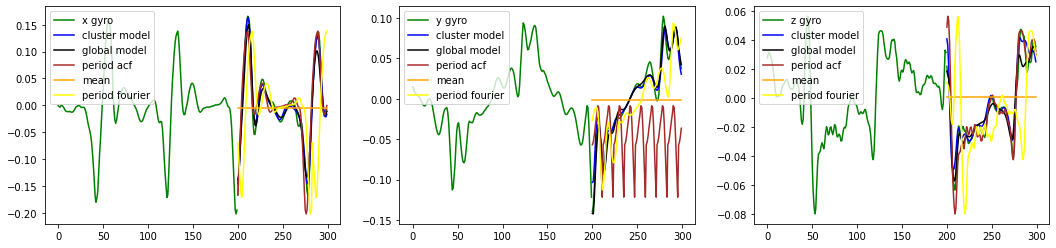

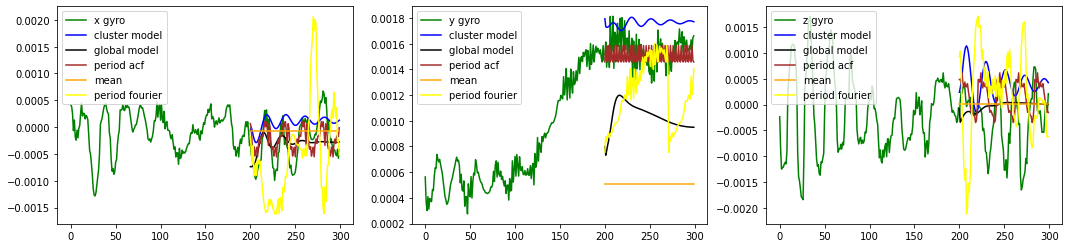

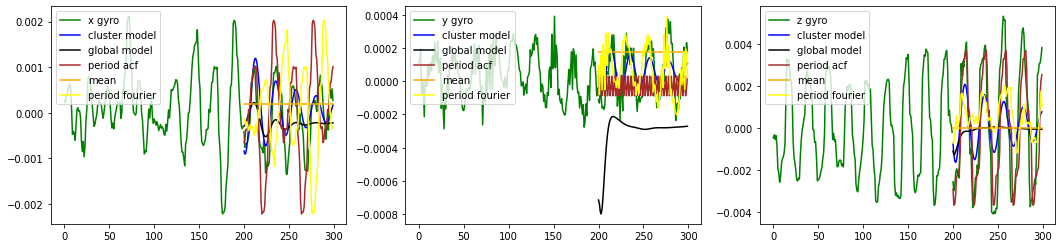

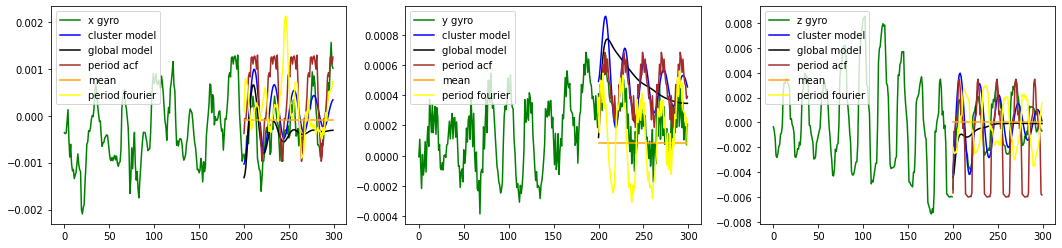

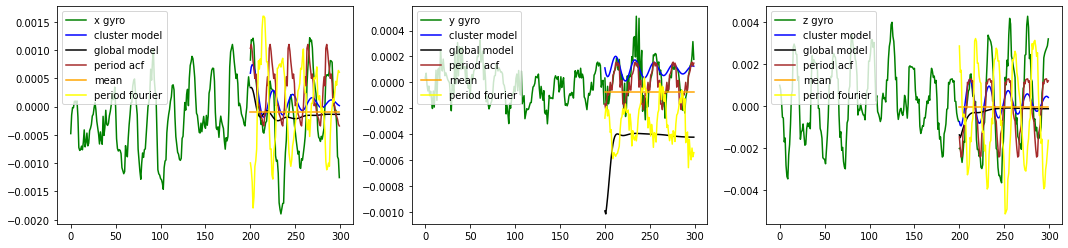

In [13]:
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)
plot_forecasts_multi(X_test[idx_threshold], [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)

In [14]:
idx_threshold = np.where(predictions_cluster_class_acf_index == 0)[0]

ratio = len(idx_threshold)/X_test.shape[0]
print(ratio)

forecast_for_threshold_acf = predictions_cluster_class_acf[idx_threshold]
forecast_x_acf = forecast_for_threshold_acf[:,:,0].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_y_acf = forecast_for_threshold_acf[:,:,1].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_z_acf = forecast_for_threshold_acf[:,:,2].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))

true_x = y_test[idx_threshold,:,0].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_y = y_test[idx_threshold,:,1].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_z = y_test[idx_threshold,:,2].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))

baseline_dict = get_forecast_baseline_dict(X_test[idx_threshold], y_test[idx_threshold], global_forecasting_model , 3, lag, ahead, downsampling_freq, comparison_methods)

dict_forecasts_x = {"cluster model": forecast_x_acf}
dict_forecasts_y = {"cluster model": forecast_y_acf}
dict_forecasts_z = {"cluster model": forecast_z_acf}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

0.03669724770642202


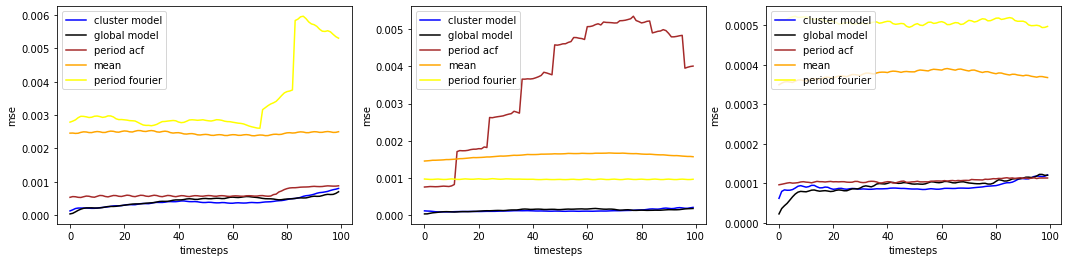

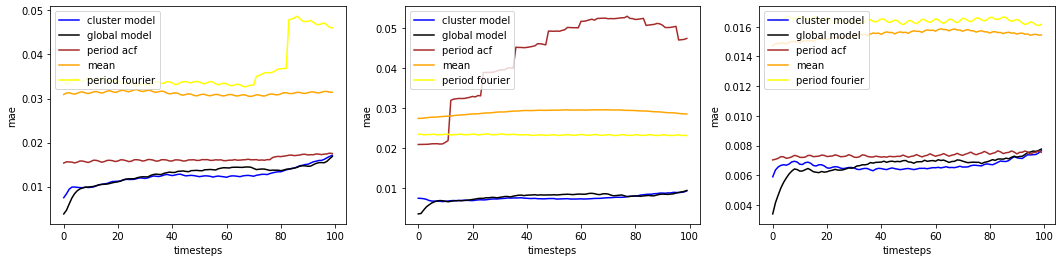

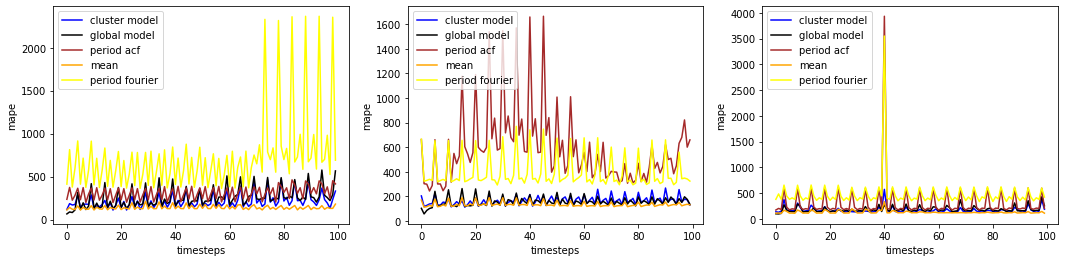

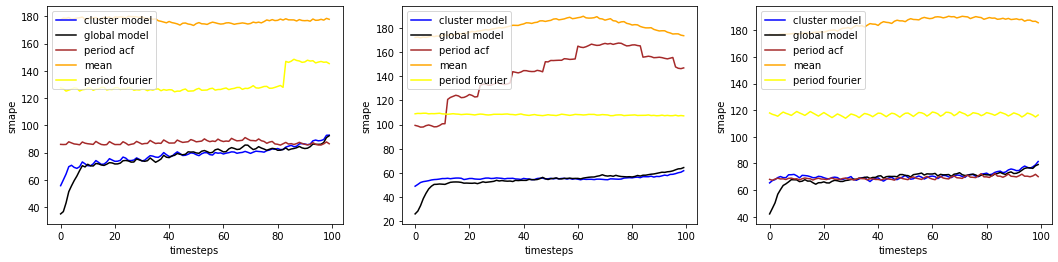

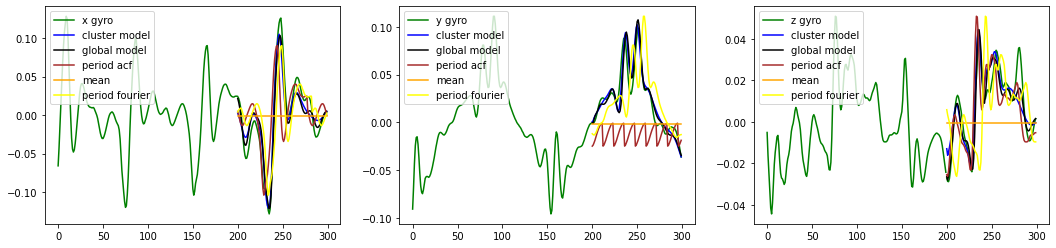

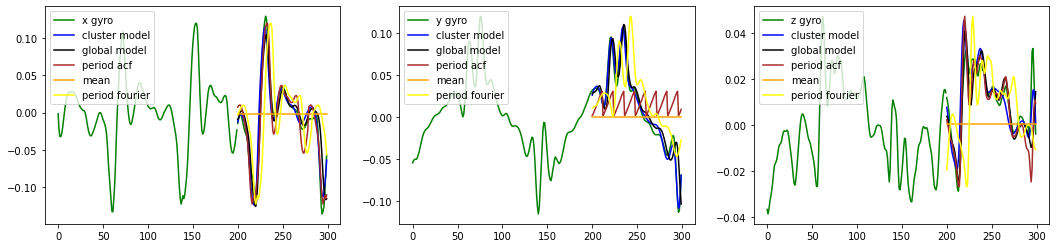

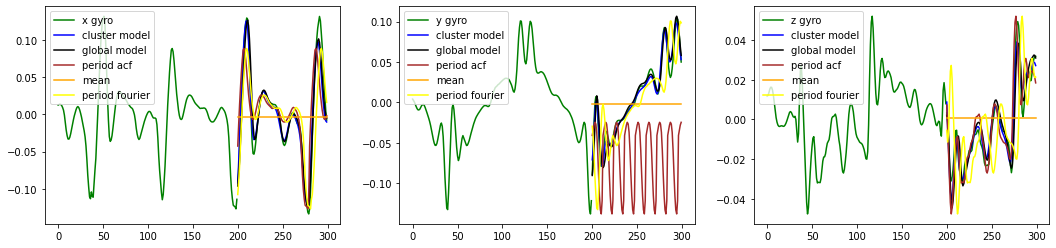

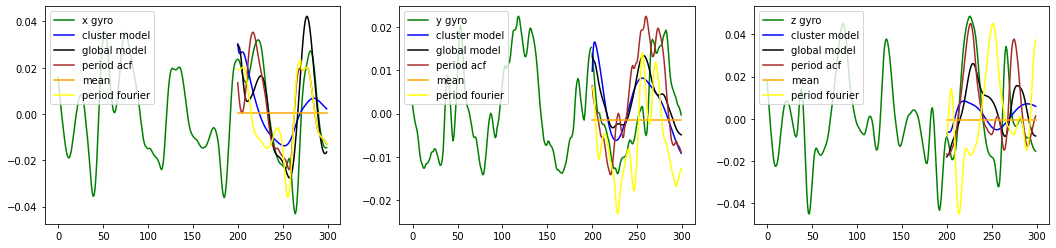

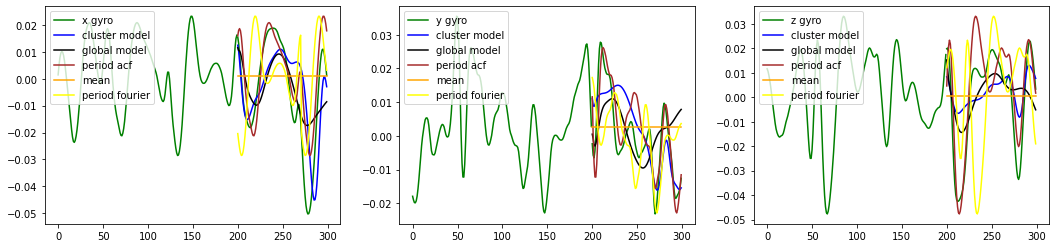

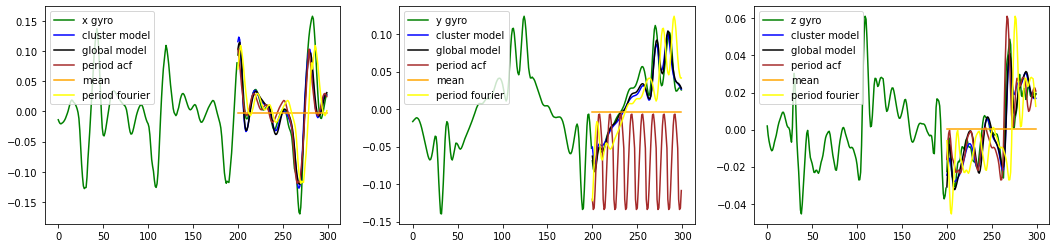

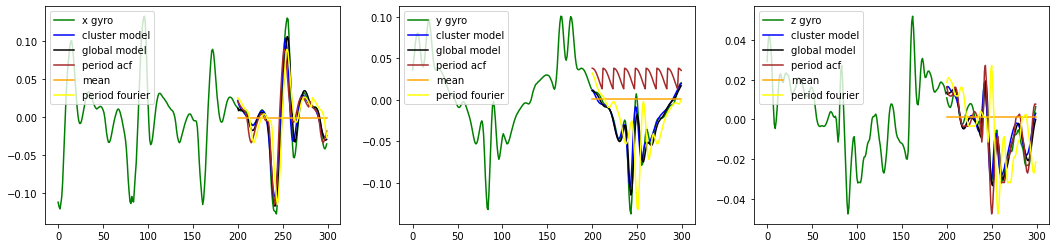

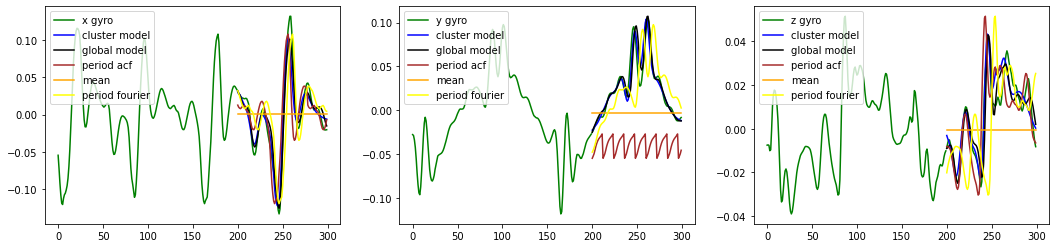

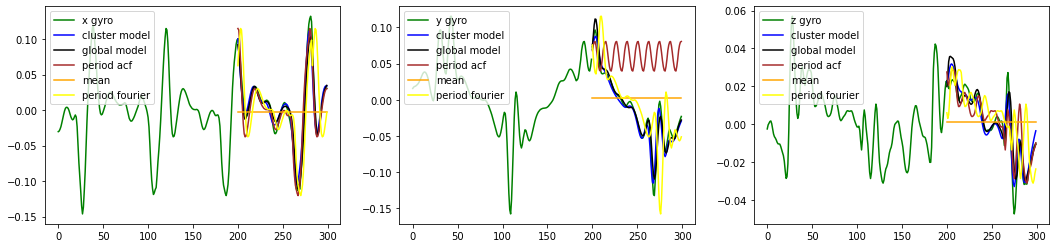

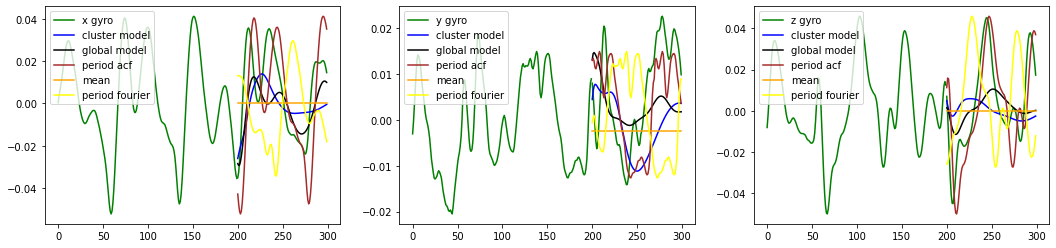

In [15]:
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)
plot_forecasts_multi(X_test[idx_threshold], [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)

In [16]:
idx_threshold = np.where(predictions_cluster_class_acf_index == 1)[0]

ratio = len(idx_threshold)/X_test.shape[0]
print(ratio)

forecast_for_threshold_acf = predictions_cluster_class_acf[idx_threshold]
forecast_x_acf = forecast_for_threshold_acf[:,:,0].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_y_acf = forecast_for_threshold_acf[:,:,1].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_z_acf = forecast_for_threshold_acf[:,:,2].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))

true_x = y_test[idx_threshold,:,0].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_y = y_test[idx_threshold,:,1].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_z = y_test[idx_threshold,:,2].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))

baseline_dict = get_forecast_baseline_dict(X_test[idx_threshold], y_test[idx_threshold], global_forecasting_model , 3, lag, ahead, downsampling_freq, comparison_methods)

dict_forecasts_x = {"cluster model": forecast_x_acf}
dict_forecasts_y = {"cluster model": forecast_y_acf}
dict_forecasts_z = {"cluster model": forecast_z_acf}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

0.11225040474905558


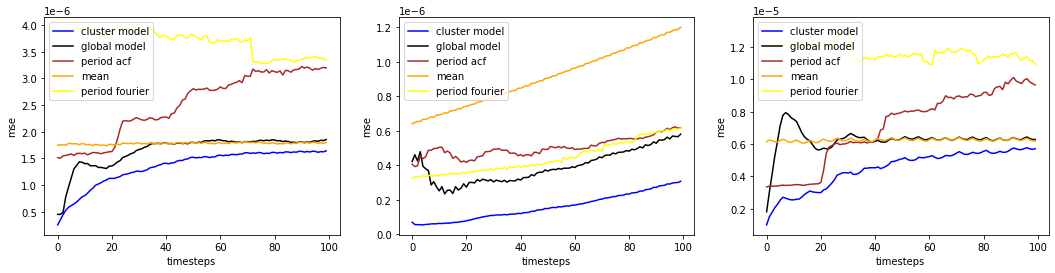

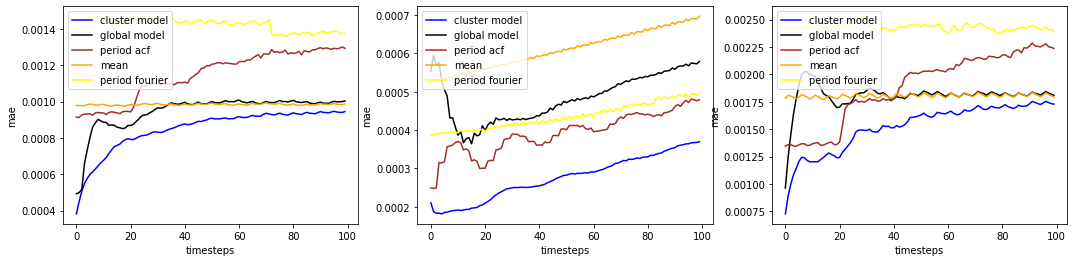

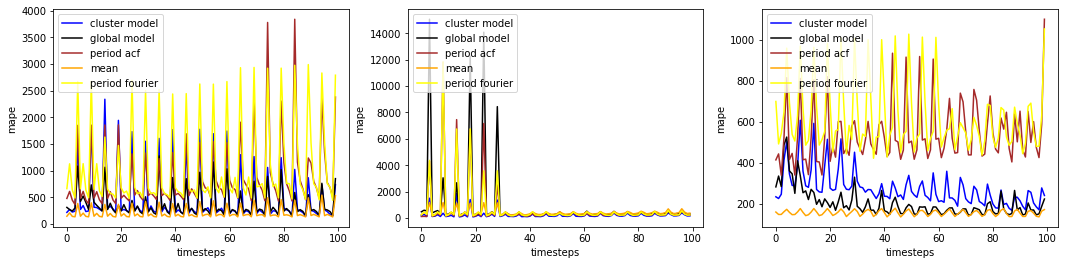

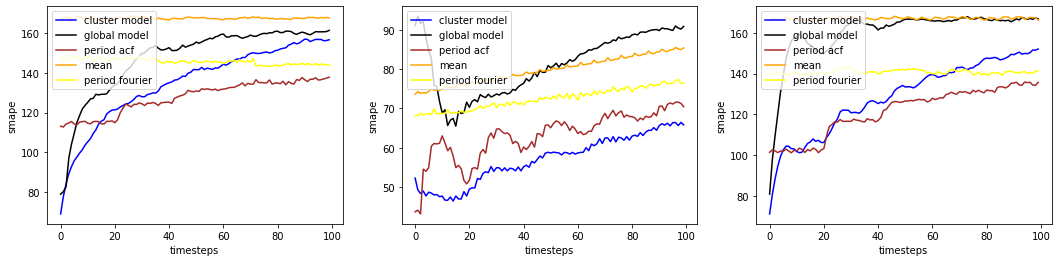

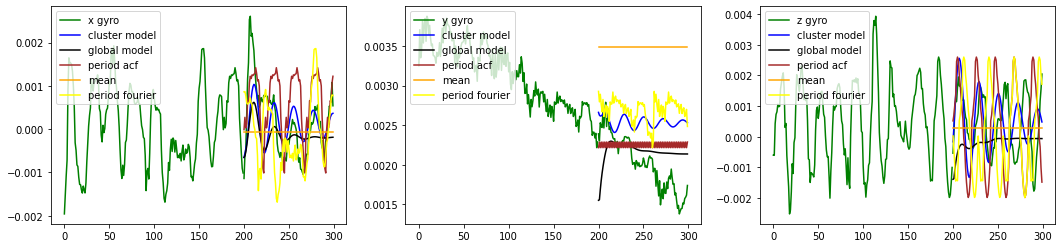

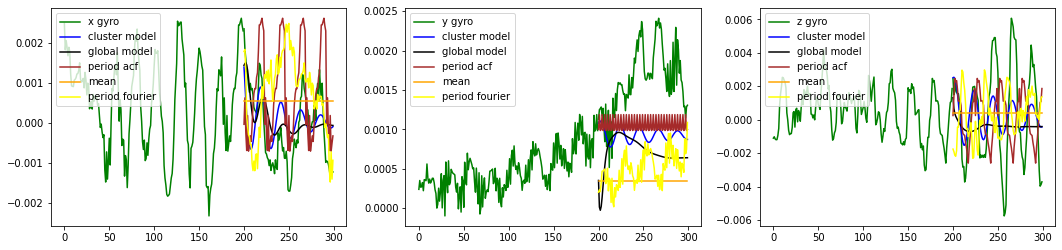

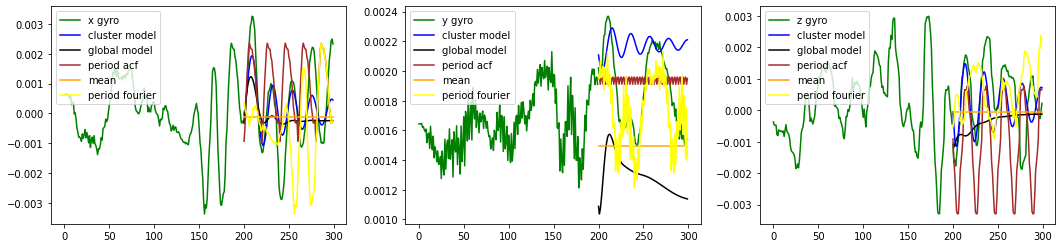

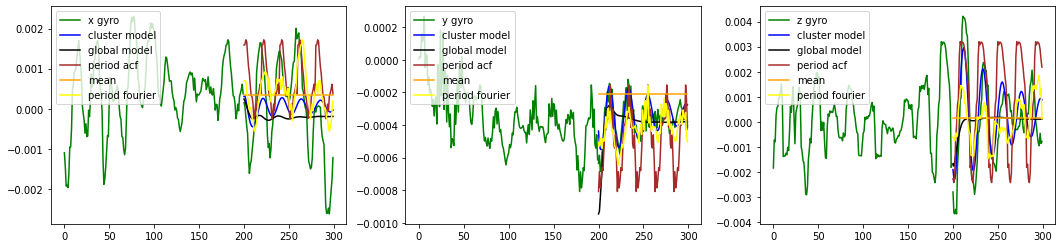

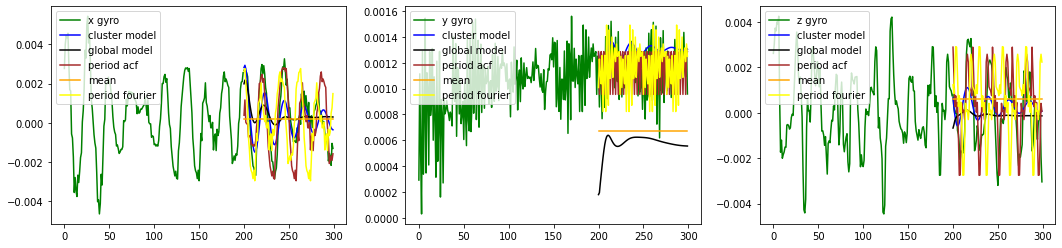

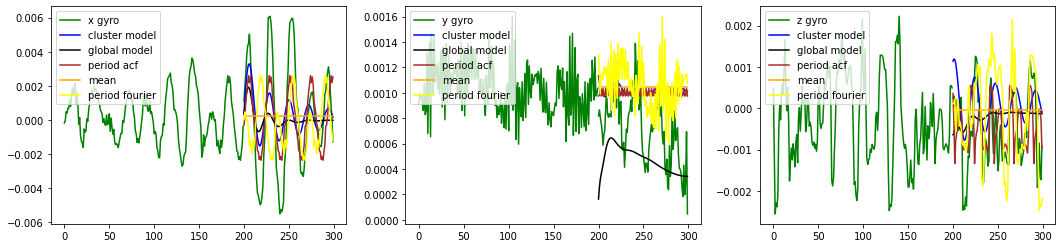

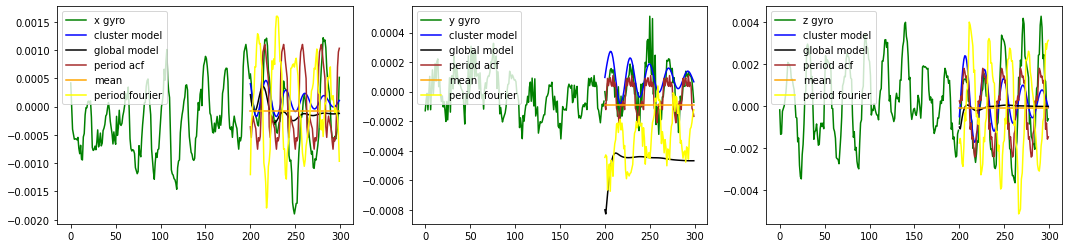

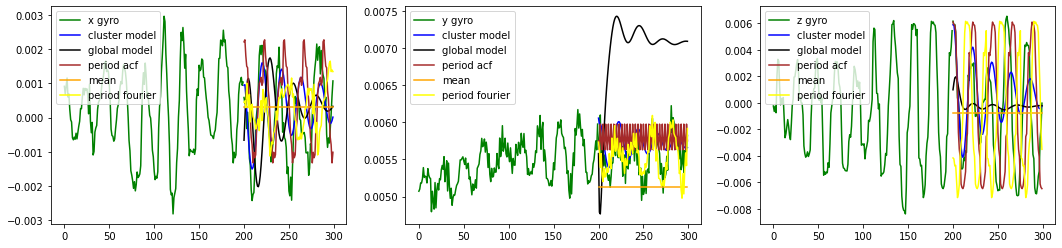

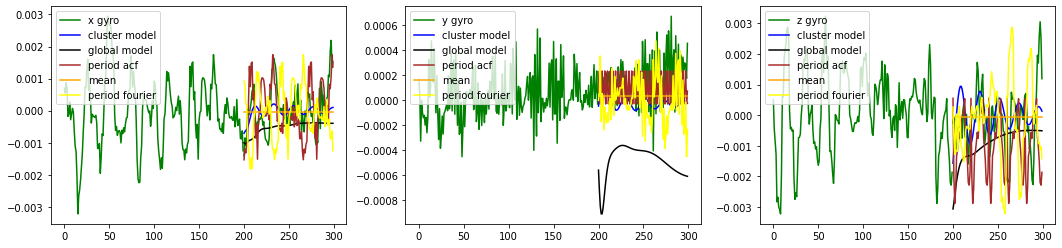

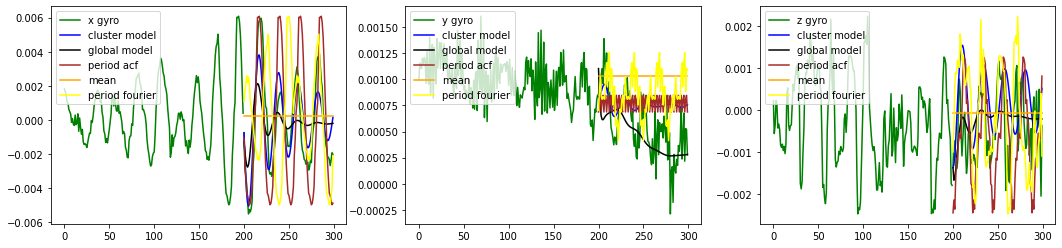

In [17]:
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)
plot_forecasts_multi(X_test[idx_threshold], [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)

0.004317323259579061


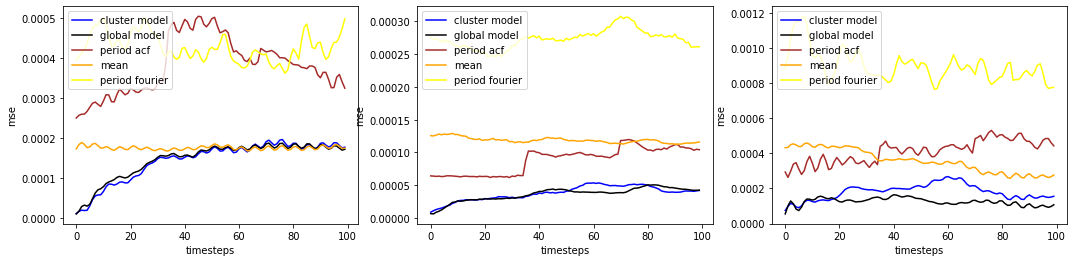

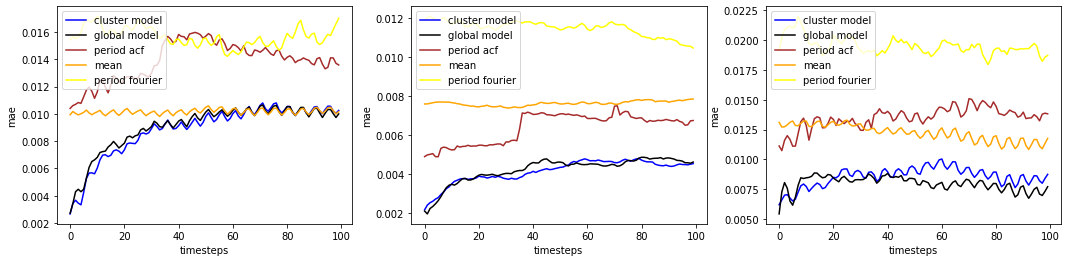

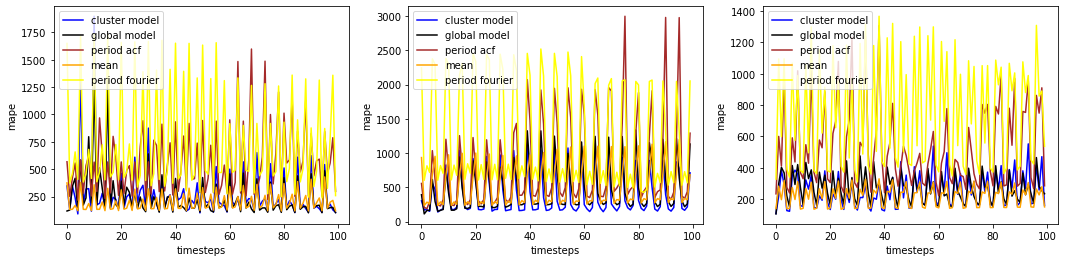

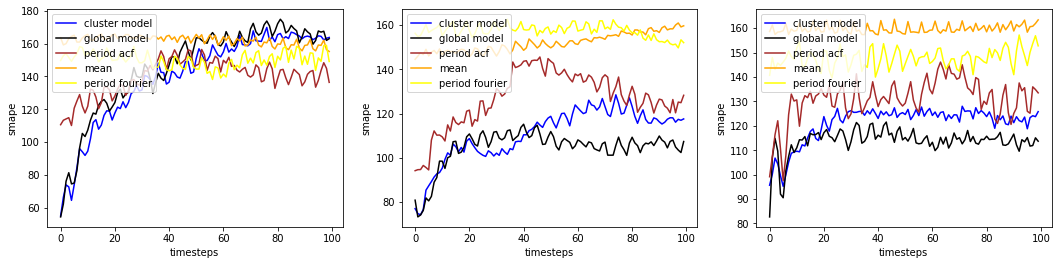

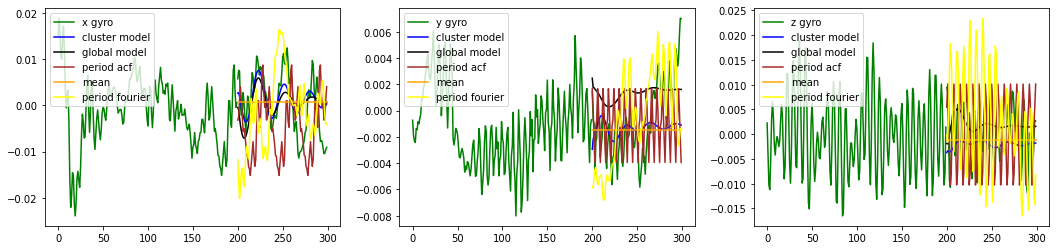

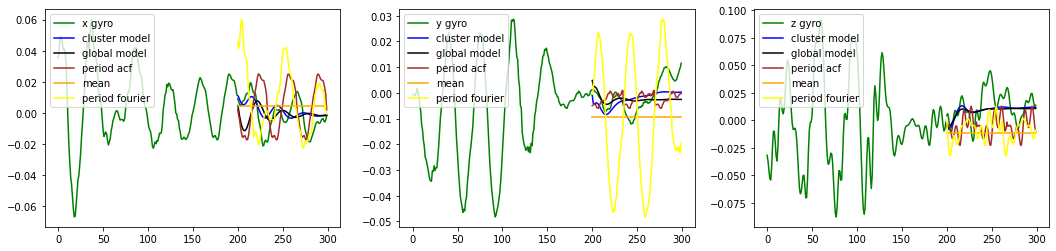

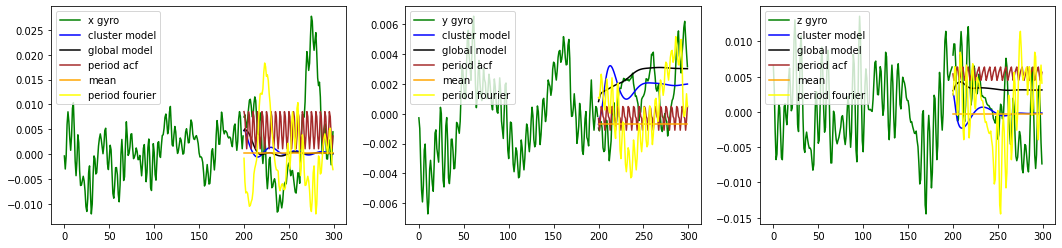

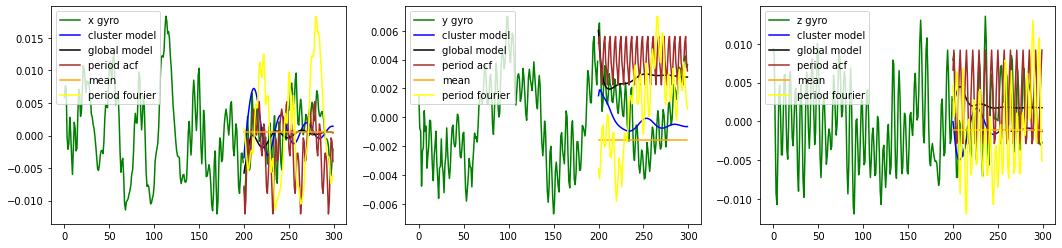

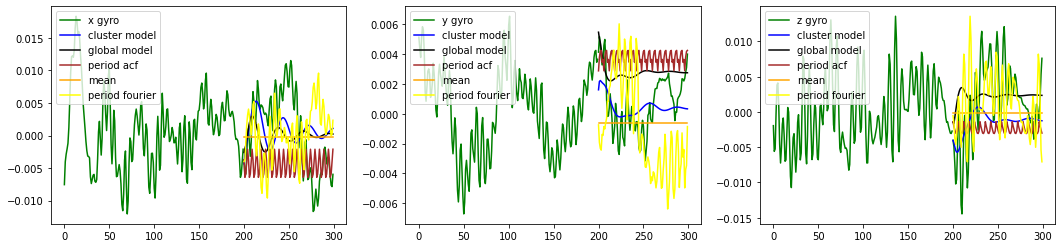

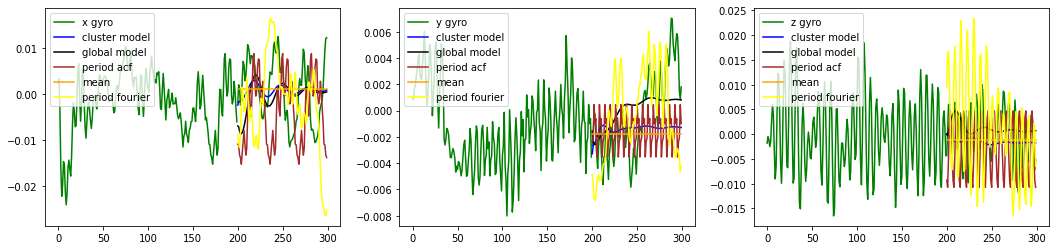

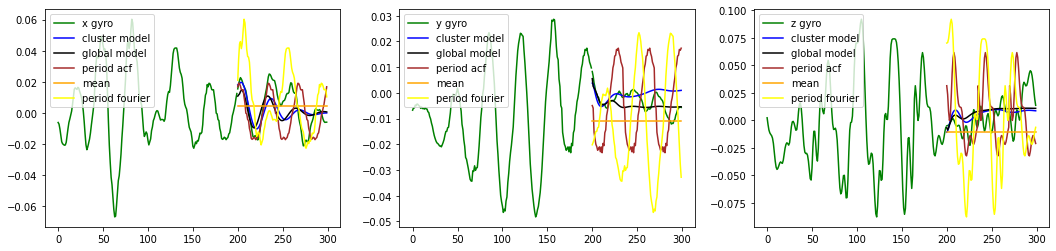

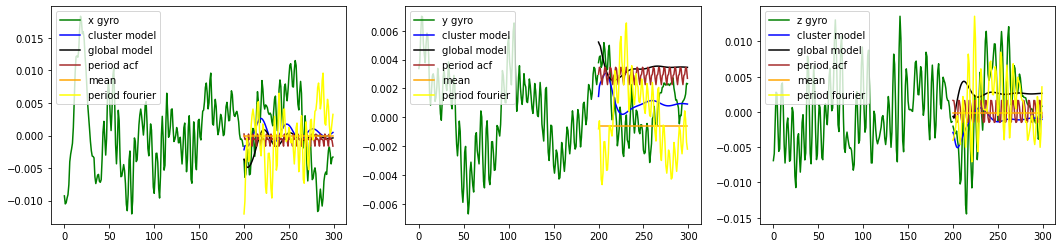

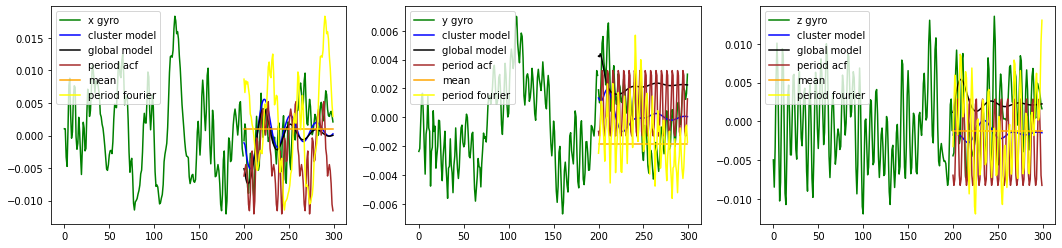

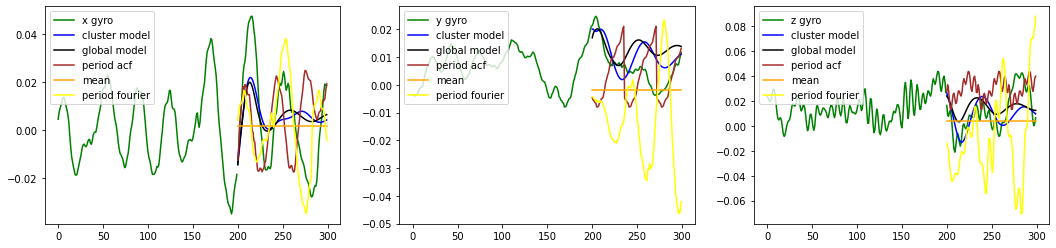

In [18]:
idx_threshold = np.where(predictions_cluster_class_acf_index == 2)[0]

ratio = len(idx_threshold)/X_test.shape[0]
print(ratio)

forecast_for_threshold_acf = predictions_cluster_class_acf[idx_threshold]
forecast_x_acf = forecast_for_threshold_acf[:,:,0].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_y_acf = forecast_for_threshold_acf[:,:,1].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_z_acf = forecast_for_threshold_acf[:,:,2].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))

true_x = y_test[idx_threshold,:,0].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_y = y_test[idx_threshold,:,1].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_z = y_test[idx_threshold,:,2].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))

baseline_dict = get_forecast_baseline_dict(X_test[idx_threshold], y_test[idx_threshold], global_forecasting_model , 3, lag, ahead, downsampling_freq, comparison_methods)

dict_forecasts_x = {"cluster model": forecast_x_acf}
dict_forecasts_y = {"cluster model": forecast_y_acf}
dict_forecasts_z = {"cluster model": forecast_z_acf}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

    
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)
plot_forecasts_multi(X_test[idx_threshold], [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)

0.008634646519158122


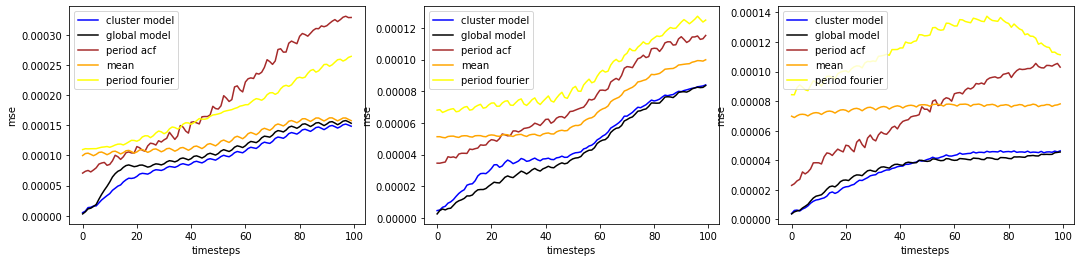

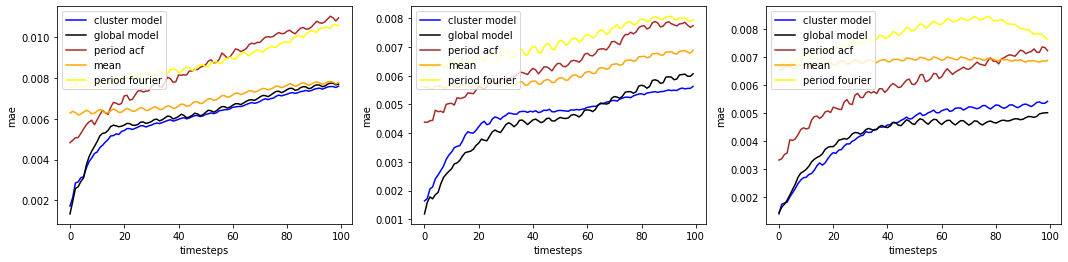

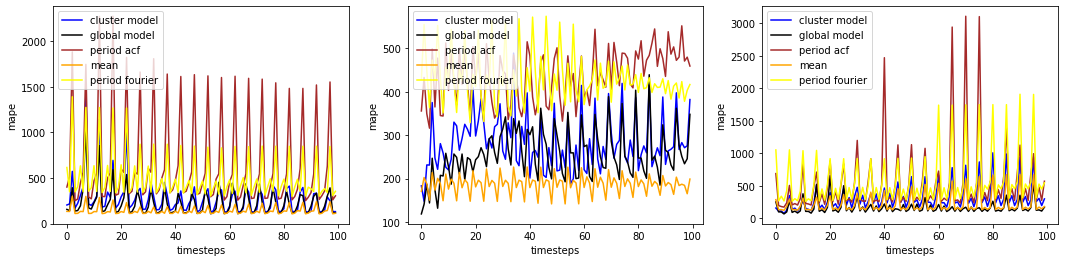

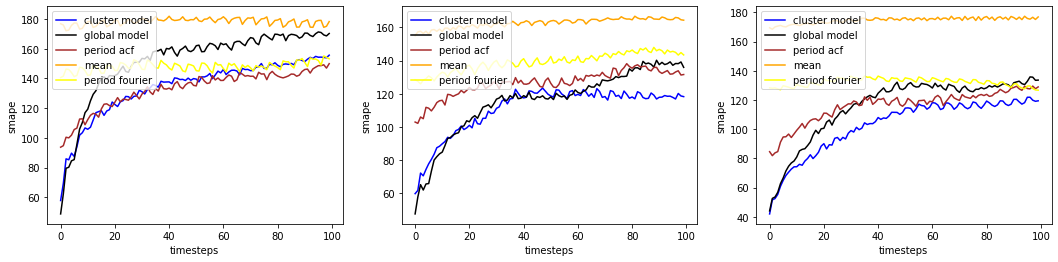

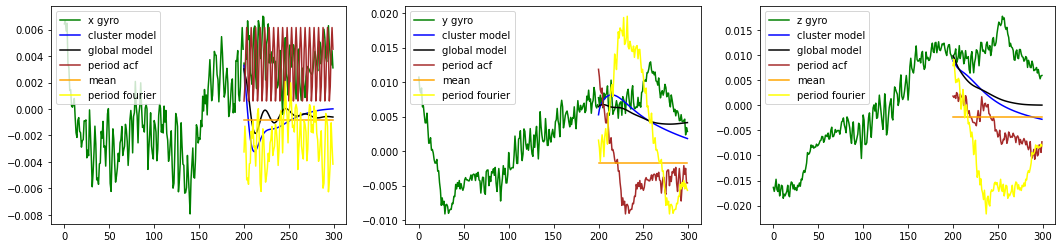

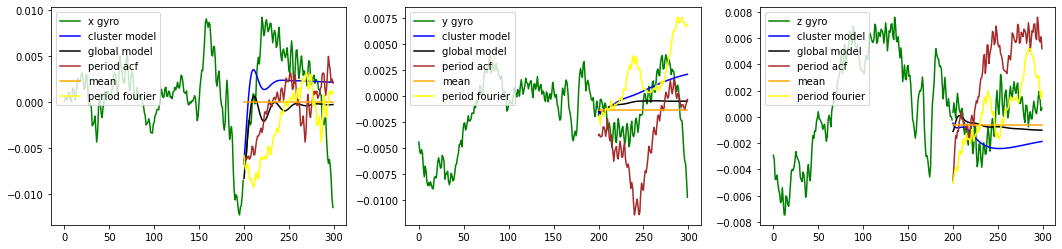

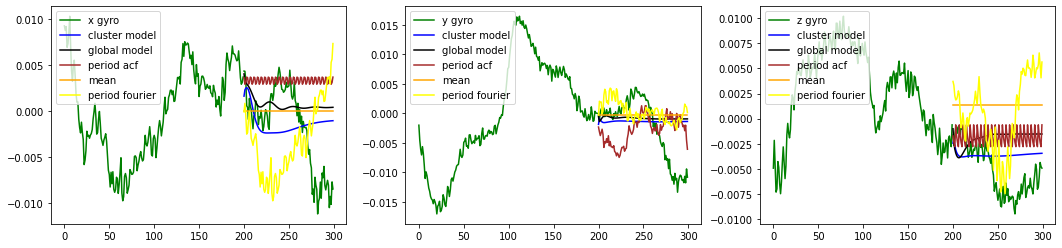

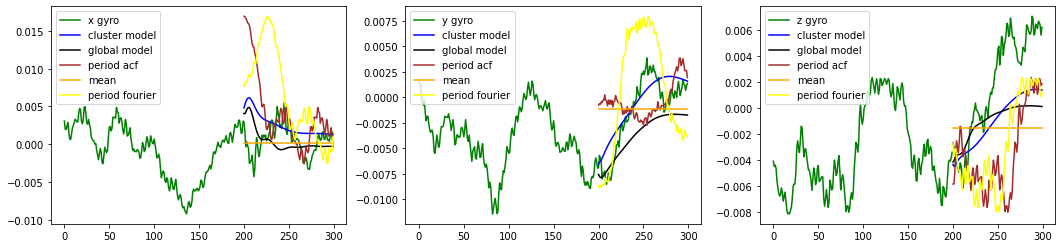

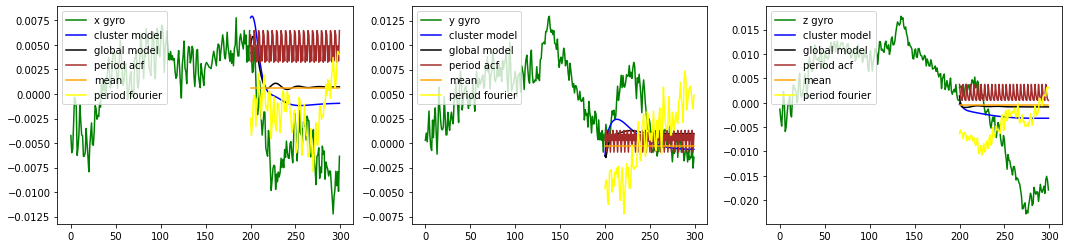

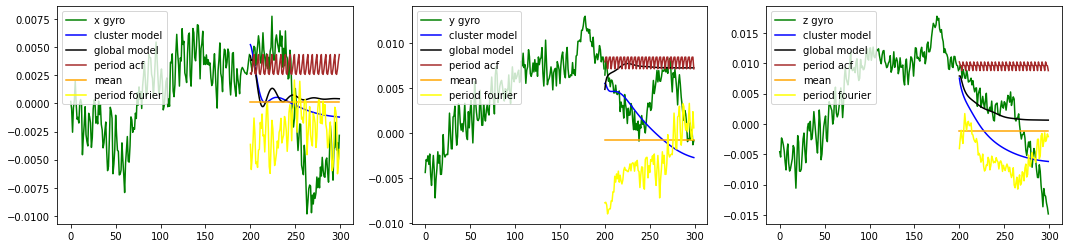

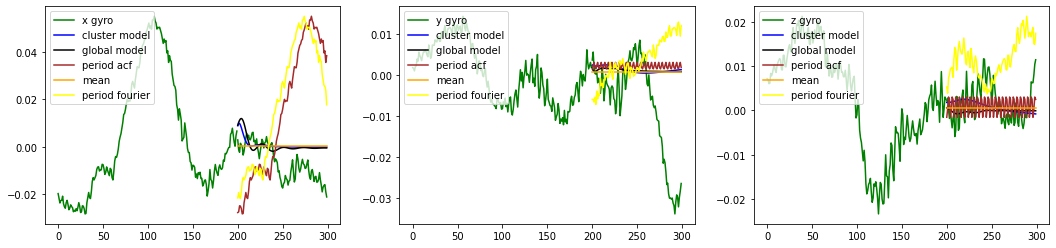

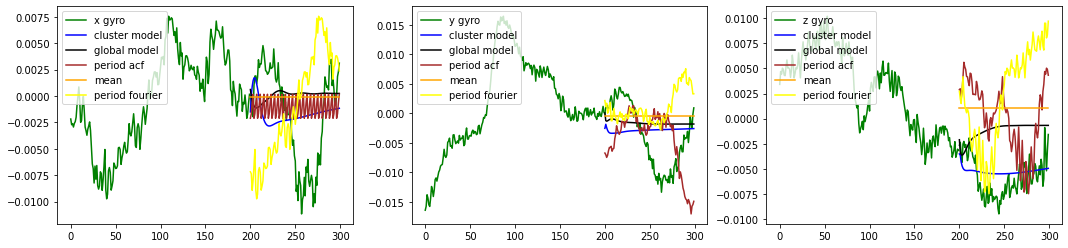

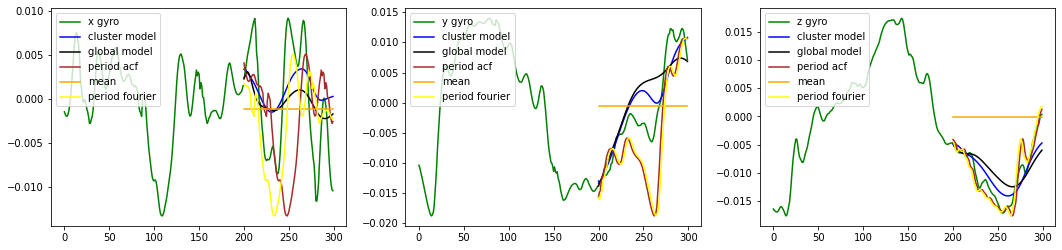

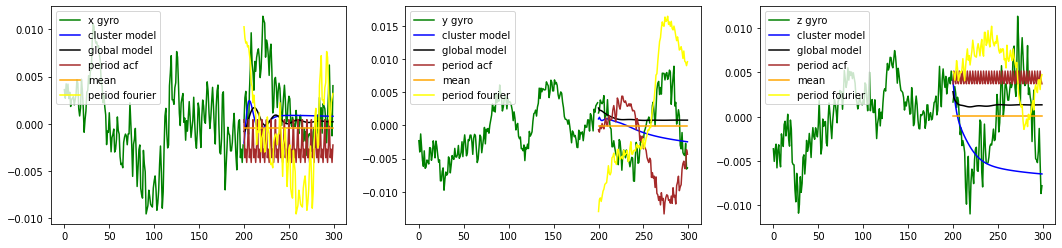

In [20]:
idx_threshold = np.where(predictions_cluster_class_acf_index == 3)[0]

ratio = len(idx_threshold)/X_test.shape[0]
print(ratio)

forecast_for_threshold_acf = predictions_cluster_class_acf[idx_threshold]
forecast_x_acf = forecast_for_threshold_acf[:,:,0].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_y_acf = forecast_for_threshold_acf[:,:,1].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))
forecast_z_acf = forecast_for_threshold_acf[:,:,2].reshape((forecast_for_threshold_acf.shape[0], forecast_for_threshold_acf.shape[1]))

true_x = y_test[idx_threshold,:,0].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_y = y_test[idx_threshold,:,1].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))
true_z = y_test[idx_threshold,:,2].reshape((y_test[idx_threshold].shape[0], y_test[idx_threshold].shape[1]))

baseline_dict = get_forecast_baseline_dict(X_test[idx_threshold], y_test[idx_threshold], global_forecasting_model , 3, lag, ahead, downsampling_freq, comparison_methods)

dict_forecasts_x = {"cluster model": forecast_x_acf}
dict_forecasts_y = {"cluster model": forecast_y_acf}
dict_forecasts_z = {"cluster model": forecast_z_acf}

for k, v in baseline_dict.items():
    dict_forecasts_x[k] = v[0]
for k, v in baseline_dict.items():
    dict_forecasts_y[k] = v[1]
for k, v in baseline_dict.items():
    dict_forecasts_z[k] = v[2]

    
plot_metrics_multi([true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color)
plot_forecasts_multi(X_test[idx_threshold], [true_x, true_y, true_z], [dict_forecasts_x, dict_forecasts_y, dict_forecasts_z], dict_forecasts_color, 10)